In [1]:
import numpy as np
import copy
import scipy as sp
from itertools import combinations
import matplotlib.pyplot as plt
from numba import njit, prange

In [2]:
def generator_basis_set(tot_sites, N_e_up, N_e_down):
    spin_up_basis = []
    spin_down_basis = []

    for comb_up in combinations(range(tot_sites), N_e_up):
        state = [0] * tot_sites
        for idx in comb_up:
            state[idx] = 1
        spin_up_basis.append(state)

    for comb_down in combinations(range(tot_sites), N_e_down):
        state = [0] * tot_sites
        for idx in comb_down:
            state[idx] = 1
        spin_down_basis.append(state)

    basis = []

    for up_state in spin_up_basis:
        for down_state in spin_down_basis:
            basis.append([up_state, down_state])
    
    return np.array(basis)



def hop_j_2_k(input_state, j, k, spin):
    if input_state[spin][j] == 0 or input_state[spin][k] == 1:
        return 0, None
    
    state = copy.deepcopy(input_state)
    
    sign = 1

    # Destrying the particle

    for i in range(j):
        if state[spin][i] == 1:
            sign = sign * (-1)
    
    state[spin][j] = 0

    # Create the particle

    for i in range(k):
        if state[spin][i] == 1:
            sign = sign * (-1)
    
    state[spin][k] = 1

    return sign, state



def map_state_2_idx(basis_set):
    return {tuple(np.concatenate((state[0], state[1]))) : i for i, state in enumerate(basis_set)}



def generate_hamiltonian_matrix(basis_set, dim, tot_sites, U, J_1, J_11, J_3, J_33):

    state_2_idx_mapping = map_state_2_idx(basis_set)
    H = np.zeros((dim, dim))

    for a in range(dim):
        state = basis_set[a].copy()

        # Interaction Potential Energy

        for i in range(tot_sites):
            H[a, a] += U * state[0][i] * state[1][i]
        
        # Kinetic Energy

        for s in range(2):
            for j in range(tot_sites):
                for k in [j + 1, j - 1, j + 3, j - 3]:
                    if (k >= tot_sites) or (k < 0):
                        continue

                    hopped_state_sign, hopped_state = hop_j_2_k(state, j, k, s)
                    
                    if hopped_state_sign == 0:
                        continue

                    b = state_2_idx_mapping[tuple(np.concatenate((hopped_state[0], hopped_state[1])))]

                    # # Test Print
                    # print(state[0], state[1], '------', s, '---', hopped_state[0], hopped_state[1], '---', hopped_state_sign, '--', b + 1)

                    if j % 2 == 0: # Identifies site A

                        if k == j + 1:
                            H[a, b] -= J_11 * hopped_state_sign

                        elif k == j - 1:
                            H[a, b] -= J_1 * hopped_state_sign

                        elif k == j + 3:
                            H[a, b] -= J_33 * hopped_state_sign
                        
                        else:
                            H[a, b] -= J_3 * hopped_state_sign
                    
                    else: # Identifies site B
                        if k == j + 1:
                            H[a, b] -= J_1 * hopped_state_sign

                        elif k == j - 1:
                            H[a, b] -= J_11 * hopped_state_sign

                        elif k == j + 3:
                            H[a, b] -= J_3 * hopped_state_sign
                        
                        else:
                            H[a, b] -= J_33 * hopped_state_sign
            
    return H



def generate_pos_sp_wf(psi, basis_set, tot_sites):
    pos_sp_state = np.zeros((2, tot_sites))  # [spin][site]

    for idx, amp in enumerate(psi):
        up_state, down_state = basis_set[idx]
        for site in range(tot_sites):
            pos_sp_state[0, site] += amp * up_state[site]
            pos_sp_state[1, site] += amp * down_state[site]

    return pos_sp_state




@njit
def generate_spin_correlation(psi, basis_set, dim, tot_sites):
    C = np.zeros((tot_sites, tot_sites))

    for j in prange(tot_sites):
        for k in prange(tot_sites):
            val = 0.0
            for idx in prange(dim):
                up, down = basis_set[idx]
                sz_j = 0.5 * (up[j] - down[j])
                sz_k = 0.5 * (up[k] - down[k])
                val += psi[idx] * sz_j * sz_k * psi[idx]
            C[j, k] = val

    return C


In [16]:
tot_sites = 8
N_e_up = tot_sites // 2
N_e_down = N_e_up
J_11 = 0.1
J_1 = 0.6
J_33 = 0.1
J_3 = 0.1
U = 10

In [17]:
basis_set = generator_basis_set(tot_sites, N_e_up, N_e_down)
dim = len(basis_set)

H = generate_hamiltonian_matrix(basis_set, dim, tot_sites, U, J_1, J_11, J_3, J_33)

# print(H)


print(f'Basis States Number: {len(basis_set)}')
print(f'Basis States:')
print(basis_set)
print(sp.linalg.ishermitian(H))

Basis States Number: 4900
Basis States:
[[[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]]

 [[1 1 1 ... 0 0 0]
  [1 1 1 ... 1 0 0]]

 ...

 [[0 0 0 ... 1 1 1]
  [0 0 0 ... 0 1 1]]

 [[0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]

 [[0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]]]
True


In [18]:
e_val, e_vec = np.linalg.eigh(H)

In [ ]:
e_vec_pos_sp = np.zeros((dim, 2, tot_sites))

for a in range(dim):
    e_vec_pos_sp[a] = generate_pos_sp_wf(e_vec[a], basis_set, tot_sites)

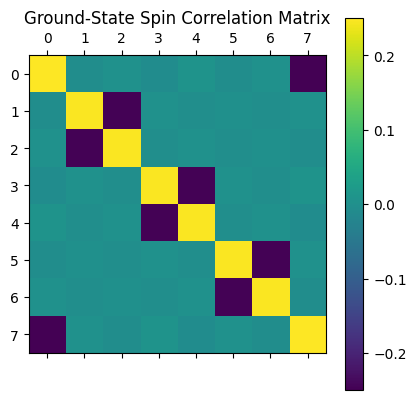

In [19]:
ground_state = e_vec[:, 0]

spin_correlation_matrix = generate_spin_correlation(ground_state, basis_set, dim, tot_sites)

plt.matshow(spin_correlation_matrix)
plt.title("Ground-State Spin Correlation Matrix")
plt.colorbar()
plt.show()

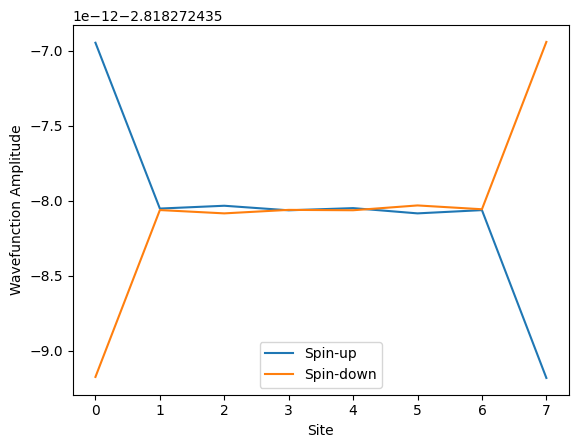

In [20]:
pos_sp_wf = generate_pos_sp_wf(ground_state, basis_set, tot_sites)
plt.plot(pos_sp_wf[0], label="Spin-up")
plt.plot(pos_sp_wf[1], label="Spin-down")
plt.xlabel("Site")
plt.ylabel("Wavefunction Amplitude")
plt.legend()
plt.show()